In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [4]:
from multicam.mah import get_mah

# Collect MAH data

In [5]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [6]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
ma = mah_data['ma']
am = mah_data['am']
# ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

(10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


# Construct indicators and merger ratio at each snapshot

In [7]:
# scale factor coarser bins 
min_scale, max_scale = np.min(scales), np.max(scales)
scale_bins = np.linspace(min_scale, max_scale, 20)
scale_bins

array([0.18635   , 0.22919211, 0.27203421, 0.31487632, 0.35771842,
       0.40056053, 0.44340263, 0.48624474, 0.52908684, 0.57192895,
       0.61477105, 0.65761316, 0.70045526, 0.74329737, 0.78613947,
       0.82898158, 0.87182368, 0.91466579, 0.95750789, 1.00035   ])

In [8]:
# for each simulation scale, get MM 
# first we need merger ratio at every scale 
merger_ratio_inst  = np.zeros((len(cat), len(scales)))
merger_ratio_present = np.zeros((len(cat), len(scales)))
for i in range(len(cat)):
    for j, idx in enumerate(indices): 
        m2_name = f'm2_a{idx}' # TODO: Check what this corresponds to
        cpg_name = f'coprog_mvir_a{idx-1}' # want coprogenitor mass at previous timestep.
        mvir_name = f'mvir_a{idx}'
        
        # get inst ratios
        m2_ratio = cat[m2_name][i].item() / cat[mvir_name][i].item()
        merger_ratio_inst[i, j] = m2_ratio
        
        # present ratios
        m2_ratio = cat[m2_name][i] / cat['mvir'][i].item()
        merger_ratio_present[i, j] = m2_ratio
    

In [9]:
# construct indicator for each halo whether they have a MM in a given scale bine 
Mu = [0.3/1.3, 0.1 / 1.1 , 0.03 / (1 + 0.03), 0.01 / 1.01]
inst_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))
present_mask = np.zeros((len(Mu), len(cat), len(scale_bins)-1))

# ignore all nanmax warning, these will return np.nan's which is expected. 
warnings.simplefilter("ignore", category=RuntimeWarning)

for kk, mu in enumerate(Mu):
    for jj in range(len(scale_bins) - 1):
        # get largest merger ratio in this scale bin
        mask = (scales >= scale_bins[jj]) & (scales < scale_bins[jj+1])
        inst_mask[kk, :, jj] = np.nanmax(merger_ratio_inst[:, mask], axis=1) > mu
        present_mask[kk, :, jj] = np.nanmax(merger_ratio_present[:, mask], axis=1) > mu

In [10]:
x1 = ma

mask2 = np.isnan(merger_ratio_inst)
x2 = np.where(mask2, 0, merger_ratio_inst)

# use scale_bins instead of scales, take max over mergers in each bin.
x3 = np.zeros((x2.shape[0], scale_bins.shape[0]))
for ii, scale in enumerate(scales):
    jj = np.where(scale >= scale_bins)[0][-1]
    arr = np.vstack([x3[:, jj], x2[:, ii]])
    assert arr.shape == (2, 10000)
    x3[:, jj] = np.max(arr, axis=0)

# Phil's new figure

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# for a single fixed scale bin, as a function merger ratio, plot diff between 
# true and predicted concentration (by standard multicam) i.e. median, 25th, 75th percentile
# additionally, add another line corresponding to the model trained only on 1 additional feature
# corresponding to the merger ratio of that scale bin (extra information)


0.7432973684210527

scale_bin: 0.7004552631578947
scale_bin: 0.7432973684210527
scale_bin: 0.8718236842105264


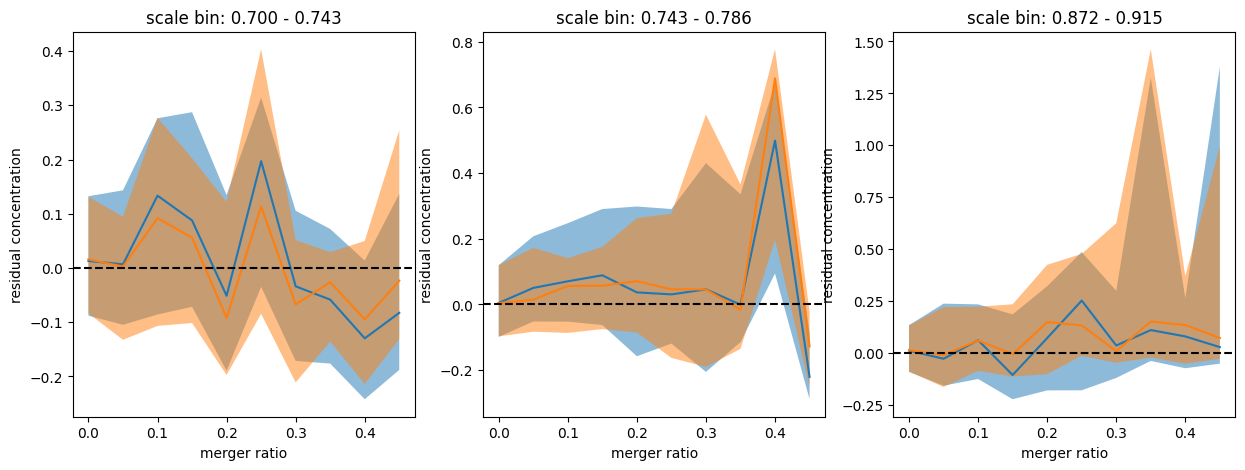

In [21]:
xgb_init = {'max_depth': 7, 'n_estimators': 1000, 'eta': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'early_stopping_rounds': 100,}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for ii, (ax, scale_bin) in enumerate(zip(axes, [0.72, 0.78, 0.88])):
    scale_idx = np.where(scale_bin >= scale_bins)[0][-1]
    assert scale_bins[scale_idx] <= scale_bin < scale_bins[scale_idx+1]
    print('scale_bin:', scale_bins[scale_idx])


    # train standard xgb
    from multicam.models import XGB
    x1 = ma[:,::10]
    x31 = x3[:, scale_idx][:, None]
    x = np.hstack([x1, x31])
    y = cat['cvir'][:, None]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
    x_test, x_eval, y_test, y_eval = train_test_split(x_test, y_test, test_size=0.2)


    # no merger ratio
    xgb_fit1 = {'verbose': False, 'eval_set': [(x_eval[:, :-1], y_eval)]}
    xgb1 = XGB(17, 1, xgb_init, xgb_fit1, use_multicam=False, use_multicam_no_ranks=False)
    xgb1.fit(x_train[:,:-1], y_train)

    #w/ merger ratio
    xgb_fit2 = {'verbose': False, 'eval_set': [(x_eval, y_eval)]}
    xgb2 = XGB(18, 1, xgb_init, xgb_fit2, use_multicam=False, use_multicam_no_ranks=False)
    xgb2.fit(x_train, y_train)


    # now let's look at the residual curves for each of these models
    # just concentration for now
    y_pred1 = xgb1.predict(x_test[:,:-1])
    y_pred2 = xgb2.predict(x_test)

    # concentration residuals
    res1 = (y_pred1[:,0] - y_test[:,0]) / y_test[:,0] 
    res2 = (y_pred2[:,0] - y_test[:,0]) / y_test[:,0]

    # plot median concentration as a function of merger ratio for this scale bin
    # plot 25th and 75th percentile as well
    merger_ratio_bins = np.linspace(0, 0.5, 11)
    median1 = np.zeros(len(merger_ratio_bins)-1)
    median2 = np.zeros(len(merger_ratio_bins)-1)
    low1 = np.zeros(len(merger_ratio_bins)-1)
    low2 = np.zeros(len(merger_ratio_bins)-1)
    high1 = np.zeros(len(merger_ratio_bins)-1)
    high2 = np.zeros(len(merger_ratio_bins)-1)

    for ii in range(len(merger_ratio_bins)-1):
        x31_test = x_test[:, -1]
        mask = (x31_test >= merger_ratio_bins[ii]) & (x31_test < merger_ratio_bins[ii+1])
        median1[ii] = np.median(res1[mask])
        median2[ii] = np.median(res2[mask])
        low1[ii] = np.percentile(res1[mask], 25)
        low2[ii] = np.percentile(res2[mask], 25)
        high1[ii] = np.percentile(res1[mask], 75)
        high2[ii] = np.percentile(res2[mask], 75)

    ax.plot(merger_ratio_bins[:-1], median1, label='standard xgboost')
    ax.plot(merger_ratio_bins[:-1], median2, label='xgboost + merger ratio')
    ax.fill_between(merger_ratio_bins[:-1], low1, high1, alpha=0.5)
    ax.fill_between(merger_ratio_bins[:-1], low2, high2, alpha=0.5)
    ax.set_xlabel('merger ratio')
    ax.set_ylabel('residual concentration')
    ax.set_title(f'scale bin: {scale_bins[scale_idx]:.3f} - {scale_bins[scale_idx+1]:.3f}')

    if ii == 0:
        ax.legend()

    ax.axhline(0, color='k', linestyle='--')

In [23]:
x_test.shape

(4000, 18)